In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import scipy.sparse
from scipy.sparse import hstack, csr_matrix 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression # # class = 'balanced to lower the skewness of score 5
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import TruncatedSVD

import string
import collections

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
X_train_origin_processed = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/X_train_origin_processed_NLP.csv")

In [5]:
X_sub = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/X_sub_NLP.csv")

In [6]:
X_train_origin_processed = X_train_origin_processed.drop(columns = ['Summary'])
X_sub = X_sub.drop(columns = ['Summary'])

In [7]:
def process_train(dataframe):
  temp1 = dataframe['Text'].astype(str)
  vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
  temp_tfidf = vectorizer.fit_transform(temp1)
  print(temp_tfidf.shape)
  svd = TruncatedSVD(n_components=100, random_state=0) # reduce dimensionality
  temp_tfidf2 = svd.fit_transform(temp_tfidf)
  print(temp_tfidf2.shape)
  temp_tfidf3 = csr_matrix(temp_tfidf2) # convert back to sparse matix
  temp2 = dataframe[['HelpfulnessNumerator',	'HelpfulnessDenominator',	'film_avg',	'user_avg',	'S',	'T']]
  temp3 = hstack((temp2, temp_tfidf3)) # combine it with the rest
  temp4 = csr_matrix(temp3) # transfer into a sparse matrix
  print(temp4.shape)
  return temp4, vectorizer, svd

def process_sub(dataframe, vectorizer, svd):
  temp1 = dataframe['Text'].astype(str)
  temp_tfidf = vectorizer.transform(temp1)
  print(temp_tfidf.shape)
  temp_tfidf2 = svd.transform(temp_tfidf) # reduce dimensionality
  temp_tfidf3 = csr_matrix(temp_tfidf2) # convert back to sparse matix
  temp2 = dataframe[['HelpfulnessNumerator',	'HelpfulnessDenominator',	'film_avg',	'user_avg',	'S',	'T']]
  temp3 = hstack((temp2, temp_tfidf3)) # combine it with the rest
  temp4 = csr_matrix(temp3) # transfer into a sparse matrix
  print(temp4.shape)
  return temp4


In [8]:
''' X_train_new, vec, svd = process_train(X_train_origin_processed) '''

' X_train_new, vec, svd = process_train(X_train_origin_processed) '

In [9]:
''' X_sub_new = process_sub(X_sub, vec, svd) '''

' X_sub_new = process_sub(X_sub, vec, svd) '

In [10]:
''' scipy.sparse.save_npz('/content/gdrive/My Drive/Colab Notebooks/data/X_train_new.npz', X_train_new) '''

" scipy.sparse.save_npz('/content/gdrive/My Drive/Colab Notebooks/data/X_train_new.npz', X_train_new) "

In [11]:
''' scipy.sparse.save_npz('/content/gdrive/My Drive/Colab Notebooks/data/X_sub_new.npz', X_sub_new) '''

" scipy.sparse.save_npz('/content/gdrive/My Drive/Colab Notebooks/data/X_sub_new.npz', X_sub_new) "

In [12]:
X_train_new = scipy.sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/data/X_train_new.npz')
X_sub_new = scipy.sparse.load_npz('/content/gdrive/My Drive/Colab Notebooks/data/X_sub_new.npz')

In [41]:
# split the set
X_train = X_train_new
Y_train = X_train_origin_processed['Score']

In [43]:
Y_train.head(10)

0    4.0
1    3.0
2    3.0
3    5.0
4    4.0
5    5.0
6    5.0
7    5.0
8    5.0
9    5.0
Name: Score, dtype: float64

In [44]:
# Learn the model
model = LinearRegression().fit(X_train, Y_train)

RMSE on testing set =  0.7012115894867887


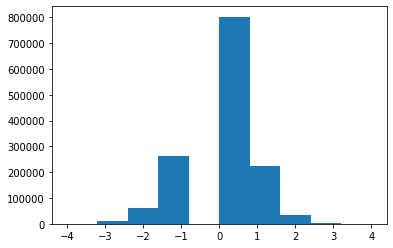

RMSE on testing set =  0.7168360246233899


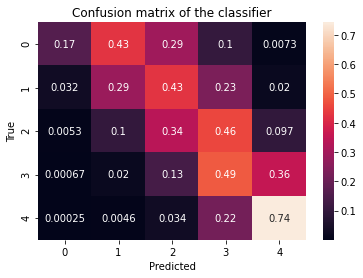

In [132]:
def get_score(n): # mannually tune the parameters
  if n > 4.25:
    return 5
  elif n > 3.49:
    return 4
  elif n > 2.8:
    return 3
  elif n > 1.8:
    return 2
  return 1

# Evaluate your model on the testing set
Y_train_pred = model.predict(X_train)
print("RMSE on testing set = ", mean_squared_error(Y_train, Y_train_pred))
Y_train_pred = np.array([get_score(n) for n in Y_train_pred])
Y_train_diff = np.array(Y_train) - np.array(Y_train_pred)
plt.hist(Y_train_diff, bins=10)
plt.show()

# Evaluate your model on the testing set
print("RMSE on testing set = ", mean_squared_error(Y_train, Y_train_pred))

# Plot a confusion matrix
cm = confusion_matrix(Y_train, Y_train_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [133]:
X_sub['Score'] = model.predict(X_sub_new)
X_sub.head()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Text,film_avg,user_avg,S,T,Score
0,5,0,0,This has been a favorite movie of mine for a l...,4.483871,5.00,5,5,5.398648
1,11,0,0,Even though i don't care for Henry Winklers a...,4.483871,4.75,3,2,4.645272
2,17,0,0,Anorher good movie for holiday watchers..a lit...,4.483871,4.00,2,4,4.120001
3,46,10,14,My wife and I grew up in New Hampshire where t...,4.483871,3.00,5,4,3.540119
4,47,0,1,"This is a first for me, I didn't like this mov...",4.483871,4.50,2,2,2.941525


In [134]:
X_sub['Score'] = X_sub['Score'].map(lambda x: get_score(x))
X_sub.head()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Text,film_avg,user_avg,S,T,Score
0,5,0,0,This has been a favorite movie of mine for a l...,4.483871,5.00,5,5,5
1,11,0,0,Even though i don't care for Henry Winklers a...,4.483871,4.75,3,2,5
2,17,0,0,Anorher good movie for holiday watchers..a lit...,4.483871,4.00,2,4,4
3,46,10,14,My wife and I grew up in New Hampshire where t...,4.483871,3.00,5,4,4
4,47,0,1,"This is a first for me, I didn't like this mov...",4.483871,4.50,2,2,3


In [135]:
print(X_sub.shape)

(300000, 9)


In [136]:
# Create the submission file
X_submission = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/X_submission.csv')
X_submission['Score'] = X_sub['Score']
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/gdrive/My Drive/Colab Notebooks/data/submission_V11_NLP_LRonWHOLE2.csv", index=False)

In [137]:
#X_submission.head(30)
print(submission.shape)

(300000, 2)
